In [1]:
import tensorflow as tf
print(tf.__version__)


2.18.1


In [2]:
import numpy as np
import zipfile, os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [3]:
zip_path = "olivetti_faces.npy.zip"   # zipped training data
extract_dir = "data_X"

# unzip if not already extracted
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

# load X (faces) and y (labels)
X = np.load(os.path.join(extract_dir, "olivetti_faces.npy"))
y = np.load("olivetti_faces_target.npy")

print("X shape:", X.shape)   # (400, 64, 64)
print("y shape:", y.shape)   # (400,)


X shape: (400, 64, 64)
y shape: (400,)


Pixel Statistics:
Mean: 0.5470
Std Dev: 0.1725
Min: 0.0000
Max: 1.0000


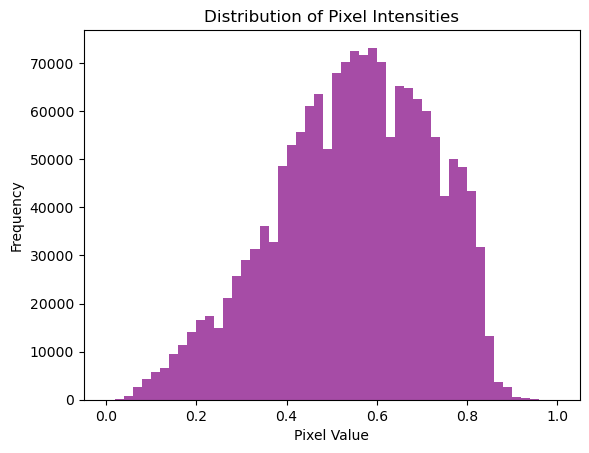

In [17]:
# ---- Descriptive statistics ----
print("Pixel Statistics:")
print(f"Mean: {X.mean():.4f}")
print(f"Std Dev: {X.std():.4f}")
print(f"Min: {X.min():.4f}")
print(f"Max: {X.max():.4f}")

# ---- Histogram ----
import matplotlib.pyplot as plt

plt.hist(X.ravel(), bins=50, color='purple', alpha=0.7)
plt.title("Distribution of Pixel Intensities")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


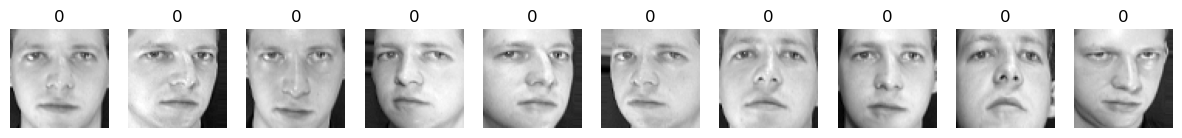

Unique classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Samples per class: [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]


In [19]:
# show 10 sample faces
fig, axes = plt.subplots(1, 10, figsize=(15, 4))
for i, ax in enumerate(axes):
    ax.imshow(X[i], cmap="gray")
    ax.set_title(f"{y[i]}")
    ax.axis("off")
plt.show()

print("Unique classes:", np.unique(y))
print("Samples per class:", np.bincount(y))


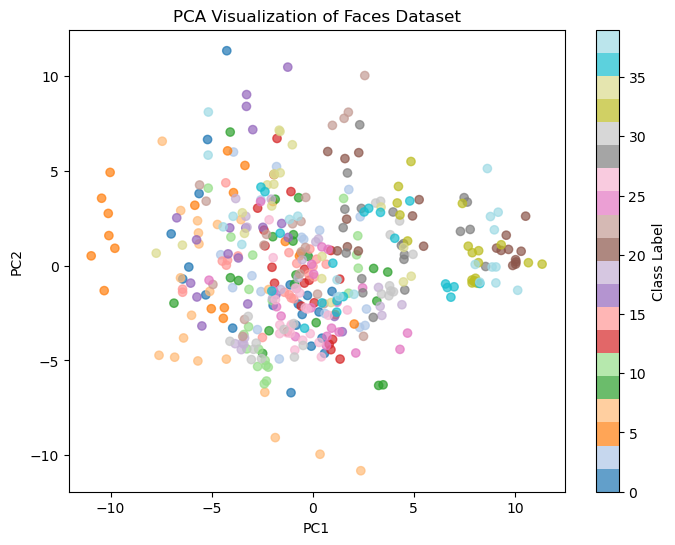

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Flatten images for PCA
X_flat = X.reshape(X.shape[0], -1)   # X is (400, 64, 64)

# Apply PCA to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='tab20', alpha=0.7)
plt.title("PCA Visualization of Faces Dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Class Label")
plt.show()


### Key Observations from EDA
- Dataset contains 400 images across 40 individuals (10 images each).
- Pixel values are normalized (range 0–1).
- Distribution of pixel intensities is centered around mid-gray with few extremes.
- PCA shows clusters by person but with some overlap.
- No major class imbalance (equal images per person).


In [25]:
# normalize images (0–1)
X = X.astype("float32") / 255.0

# add channel dimension for CNN: (N, 64, 64, 1)
X = np.expand_dims(X, axis=-1)

# one-hot encode labels
num_classes = len(np.unique(y))
y = to_categorical(y, num_classes)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


X_train: (320, 64, 64, 1) y_train: (320, 40)
X_test: (80, 64, 64, 1) y_test: (80, 40)


In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define CNN model
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(64, 64, 1)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(y_train.shape[1], activation="softmax")  # output = number of classes
])

# Compile model
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


C:\Users\moham\desktop\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 687,784 (2.62 MB)

 Trainable params: 687,784 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# ---- Baseline Model (no augmentation) ----
baseline_history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

baseline_eval = model.evaluate(X_test, y_test, verbose=0)
print(f"Baseline Accuracy: {baseline_eval[1]*100:.2f}%")


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - accuracy: 0.0188 - loss: 3.6902 - val_accuracy: 0.0250 - val_loss: 3.6889
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.0469 - loss: 3.6891 - val_accuracy: 0.0250 - val_loss: 3.6890
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.0219 - loss: 3.6903 - val_accuracy: 0.0250 - val_loss: 3.6889
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.0156 - loss: 3.6894 - val_accuracy: 0.0250 - val_loss: 3.6889
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.0188 - loss: 3.6896 - val_accuracy: 0.0250 - val_loss: 3.6889
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.0281 - loss: 3.6889 - val_accuracy: 0.0250 - val_loss: 3.6889
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.0188 - loss: 3.6891 - val_accuracy: 0.0250 - val_loss: 3.6889
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.0219 - loss: 3.6894 - val_accuracy: 0.

In [33]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(64,64,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,736 (6.22 MB)

 Trainable params: 1,629,736 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=32,
    verbose=1
)

Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.0156 - loss: 3.6899 - val_accuracy: 0.0312 - val_loss: 3.6917
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.0391 - loss: 3.6877 - val_accuracy: 0.0000e+00 - val_loss: 3.6987
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.0352 - loss: 3.6899 - val_accuracy: 0.0156 - val_loss: 3.7093
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.0117 - loss: 3.6907 - val_accuracy: 0.0000e+00 - val_loss: 3.7031
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.0234 - loss: 3.6847 - val_accuracy: 0.0000e+00 - val_loss: 3.7057
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.0195 - loss: 3.6882 - val_accuracy: 0.0000e+00 - val_loss: 3.7101
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.0312 - loss: 3.6833 - val_accuracy: 0.0000e+00 - val_loss: 3.7239
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.0312 - loss: 3.6842 - val_accuracy: 0.


✅ Test Accuracy: 0.0250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00    

C:\Users\moham\desktop\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\moham\desktop\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\moham\desktop\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


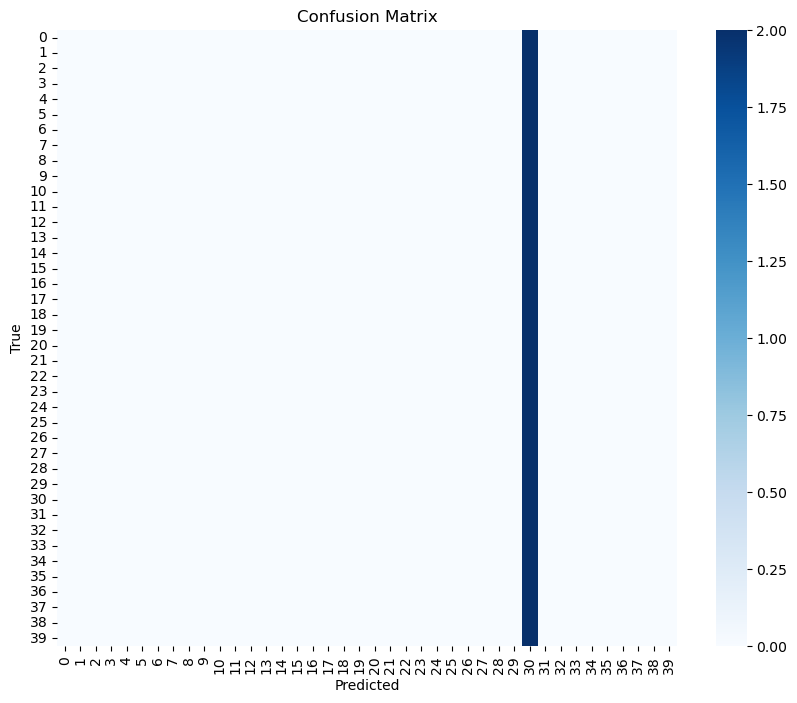

In [37]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

# predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

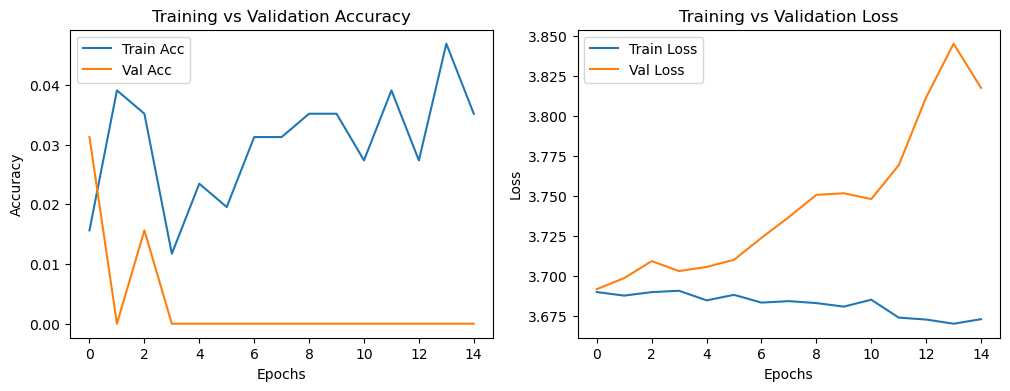

In [39]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()


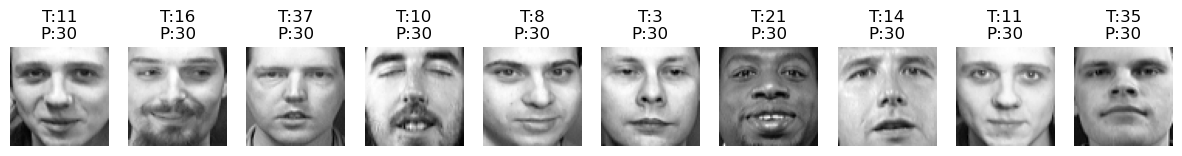

In [41]:
# =======================
indices = np.random.choice(len(X_test), 10, replace=False)
sample_images = X_test[indices]
sample_labels = y_true[indices]
sample_preds = y_pred[indices]

plt.figure(figsize=(15,4))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(sample_images[i].reshape(64,64), cmap="gray")
    plt.title(f"T:{sample_labels[i]}\nP:{sample_preds[i]}")
    plt.axis("off")
plt.show()

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [45]:
import zipfile

with zipfile.ZipFile("olivetti_faces.npy.zip", 'r') as zip_ref:
    zip_ref.extractall(".")   # extract to current folder


In [47]:
import numpy as np

X = np.load("olivetti_faces.npy")   # features
print("Shape of X:", X.shape)

# If your target labels are in a separate file:
y = np.load("olivetti_faces_target.npy")   # labels
print("Shape of y:", y.shape)


Shape of X: (400, 64, 64)
Shape of y: (400,)


In [49]:
# Normalize
X = X / 255.0

# Reshape to fit CNN input (add channel dimension)
X = X.reshape(X.shape[0], 64, 64, 1)

# One-hot encode labels
num_classes = len(np.unique(y))
y = to_categorical(y, num_classes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set:", X_train.shape, "Test set:", X_test.shape)


Train set: (320, 64, 64, 1) Test set: (80, 64, 64, 1)


In [51]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(X_train)


In [53]:
#CNN
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(64,64,1)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


C:\Users\moham\desktop\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,736 (6.22 MB)

 Trainable params: 1,629,736 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)


In [57]:
# train model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_test, y_test)
)


Epoch 1/50


C:\Users\moham\desktop\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - accuracy: 0.0281 - loss: 3.6930 - val_accuracy: 0.0250 - val_loss: 3.6889
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.0312 - loss: 3.6897 - val_accuracy: 0.0250 - val_loss: 3.6889
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.0250 - loss: 3.6892 - val_accuracy: 0.0250 - val_loss: 3.6889
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.0219 - loss: 3.6892 - val_accuracy: 0.0250 - val_loss: 3.6889
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.0125 - loss: 3.6890 - val_accuracy: 0.0250 - val_loss: 3.6889
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.0188 - loss: 3.6891 - val_accuracy: 0.0250 - val_loss: 3.6889
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.0156 - loss: 3.6889 - val_accuracy: 0.0250 - val_loss: 3.6889
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.0063 - loss: 3.6890 - val_accuracy: 0.0250 - val_

In [59]:
# evaluation(test)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes))

# Extra metrics
acc = accuracy_score(y_true, y_pred_classes)
prec = precision_score(y_true, y_pred_classes, average="macro")
rec = recall_score(y_true, y_pred_classes, average="macro")

# False Acceptance Rate (FAR) = FP / (FP + TN)
cm = confusion_matrix(y_true, y_pred_classes)
FP = cm.sum(axis=0) - np.diag(cm)
TN = cm.sum() - (FP + cm.sum(axis=1) - np.diag(cm) + np.diag(cm))
FAR = np.mean(FP / (FP + TN))

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"False Acceptance Rate (FAR): {FAR:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         2
          14       0.03      1.00      0.05         2
          15       0.00      0.00      0.00         2
          16     

C:\Users\moham\desktop\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\moham\desktop\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\moham\desktop\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\moham\desktop\Lib\site-packages\sklea

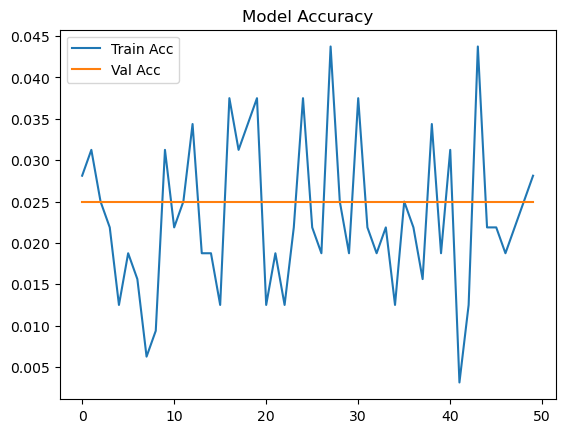

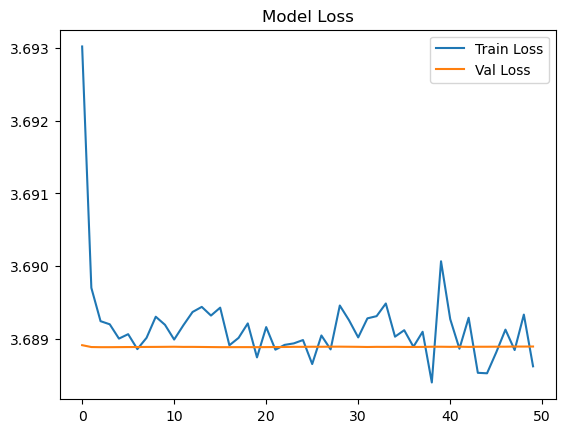

In [61]:
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Model Accuracy")
plt.show()

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Model Loss")
plt.show()

In [65]:
# ---- Improved Model (with augmentation) ----
aug_history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=30,
    verbose=1
)

# Evaluate improved model
final_eval = model.evaluate(X_test, y_test, verbose=0)
print(f"Improved Accuracy (Augmentation): {final_eval[1]*100:.2f}%")


C:\Users\moham\desktop\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.0281 - loss: 3.6893 - val_accuracy: 0.0250 - val_loss: 3.6889
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.0375 - loss: 3.6889 - val_accuracy: 0.0250 - val_loss: 3.6889
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.0094 - loss: 3.6897 - val_accuracy: 0.0250 - val_loss: 3.6889
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.0219 - loss: 3.6895 - val_accuracy: 0.0250 - val_loss: 3.6889
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.0312 - loss: 3.6893 - val_accuracy: 0.0250 - val_loss: 3.6889
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.0312 - loss: 3.6895 - val_accuracy: 0.0250 - val_loss: 3.6889
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.0312 - loss: 3.6889 - val_accuracy: 0.0250 - val_loss: 3.6889
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.0312 - loss: 3.6893 - val_accuracy: 0.

In [75]:
import pandas as pd

results = {
    "Model": ["Baseline CNN", "Improved CNN (Augmentation)"],
    "Accuracy": [baseline_eval[1], final_eval[1]],  
}

df_results = pd.DataFrame(results)
print(df_results)


                         Model  Accuracy
0                 Baseline CNN     0.025
1  Improved CNN (Augmentation)     0.025


In [84]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model():
    model = Sequential([
        Conv2D(32, (3,3), activation="relu", input_shape=(64, 64, 1)),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation="relu"),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation="relu"),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(y_train.shape[1], activation="softmax")  # output = number of classes
    ])
    return model


In [86]:
tuned_model = build_model()  


C:\Users\moham\desktop\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
